# MeteoNet Forecasts

The challenge in this notebook is to **predict the temperatures** of a place in based on weather data from previous days.

For that, the dataset of the **Ground Stations** from *MeteoNet North-West France* available on Kaggle will be used.

This dataset includes a set of features recorded at 6-minute intervals for different weather stations in the North-West part of France.

# Imports

- **numpy** for linear algebra
- **pandas** to handle dataframes
- **matplotlib** for the displays
- **sklear tools** for preprocessing, modeling, metrics...

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.impute import KNNImputer

# Quick Look

In [2]:
%%time
data0 = pd.read_csv('../input/meteonet/NW_Ground_Stations/NW_Ground_Stations/NW_Ground_Stations_2018.csv')

CPU times: user 23.4 s, sys: 4.64 s, total: 28 s
Wall time: 50.5 s


In [3]:
# Full dataset
data0

,number_sta,lat,lon,height_sta,date,dd,ff,precip,hu,td,t,psl
0,14066001,49.330,-0.430,2.0,20180101 00:00,240.0,8.2,0.0,84.0,276.75,279.25,NaN
1,14126001,49.150,0.040,125.0,20180101 00:00,NaN,NaN,0.0,98.0,278.75,279.05,NaN
2,14137001,49.180,-0.460,67.0,20180101 00:00,250.0,10.7,0.0,85.0,278.15,280.55,100690.0
3,14216001,48.928,-0.149,155.0,20180101 00:00,240.0,5.4,0.0,77.0,276.45,280.25,NaN
4,14296001,48.790,-1.040,336.0,20180101 00:00,NaN,NaN,0.0,NaN,NaN,278.35,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
22034566,86137003,47.035,0.098,96.0,20181231 23:54,40.0,2.9,0.0,88.0,278.85,280.75,NaN
22034567,86165005,46.412,0.841,153.0,20181231 23:54,60.0,3.3,0.0,95.0,278.85,279.55,NaN
22034568,86272002,46.839,0.457,120.0,20181231 23:54,NaN,NaN,0.0,NaN,NaN,NaN,NaN
22034569,91200002,48.526,1.993,116.0,20181231 23:54,270.0,0.8,0.0,96.0,279.75,280.35,NaN


In [4]:
# Investigate the number of stations
print("The full dataset is composed of {} different and unique weather stations.".format(data0['number_sta'].nunique()))

The full dataset is composed of 271 different and unique weather stations.


In [5]:
# Investigate missing records
theoretical_nb_of_rows = 10 * 24 * 365 * 271 # 10 records per hour, 24 hours per day, 365 days in 2018, 271 stations
actual_nb_of_rows = data0.shape[0]
missing_records_ratio = 1 - (actual_nb_of_rows / theoretical_nb_of_rows)
print("Ratio of missing records: {:.1f}%".format(missing_records_ratio * 100))

Ratio of missing records: 7.2%


In [6]:
data0.isna().sum()

number_sta           0
lat                  0
lon                  0
height_sta           0
date                 0
dd             8605703
ff             8598613
precip         1279127
hu             8783452
td             8786154
t              2893694
psl           17621180
dtype: int64

The *Ground Stations* dataset is composed of **6-minute interval records** of meteorological parameters for **271 unique weather stations** in the North West of France **over a full year** (2018).

After a little exploration, I noticed a few points to pay attention to:
- Not all records were successfully saved in time. In other words, there are rows missing from this dataset. The ratio of missing records on average per station is 7.2%. This could be due to a power failure or other problem at the station location. To overcome this problem, we could then use the data of the nearest station for these missing lines.
- There are sometimes missing values for some weather parameters. I have seen that this sometimes happens for several continuous moments. Again it is probably due to a broken device or being stopped for a little while. We will impute these missing values using a k-nearest neighbors imputer.
- The dataset is quite big with more than 22 million rows for a single year data records. I will reduce the task to predictions for only one weather station at a time. It means that the model will only focus on local data pour the forecasts.

# Data Reduction

Let's create a function that takes in inputs the **dataset of the stations and the coordinates** we want.

The function will return the **id of the closest station and its index** in the dataset of the stations.

Must be first created the dataset of the available stations and the associated coordinates.

It seems that for all the records of a given station number, the latitudes and longitudes sometimes slightly change. It's probably differences of digits at the time of data entry. I take the mean of all for simplicity. These are not important data used in the model anyway.

In [7]:
# Dataset of unique stations
stations = data0[['number_sta', 'lat', 'lon']].groupby('number_sta', as_index=False).mean()
stations

,number_sta,lat,lon
0,14066001,49.333064,-0.430766
1,14126001,49.146191,0.041523
2,14137001,49.180000,-0.456935
3,14216001,48.928000,-0.149000
4,14296001,48.793821,-1.037707
...,...,...,...
266,86137003,47.035000,0.098000
267,86165005,46.412000,0.841000
268,86272002,46.839245,0.455285
269,91200002,48.526096,1.993192


The function must calculate the distance between the chosen coordinate point and all the stations.

In [8]:
# Returns the closest station from the chosen coordinates
def get_closest_station(df, latitude, longitude):
    dy = abs(df['lat'] - latitude)
    dx = abs(df['lon'] - longitude)
    distance = np.sqrt(dx**2 + dy**2)
    
    # Get the station with the shortest distance
    closest_station_row = np.argmin(distance)
    closest_station_id = int(df.iloc[closest_station_row]['number_sta'])

    return closest_station_id, closest_station_row

I want to make predictions for Brest. The geographical coordinates are around:
- Latitude: 48,64
- Longitude: -1.51

Now I can scatter all the stations to see the French coast of Brittany and Normandy take shape (with a bit of imagination).

The red cross is the chosen station. All these precautions will make it possible to change stations easily at the end and make forecasts at other places.

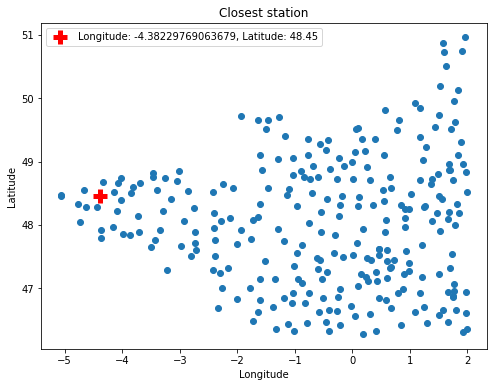

The closest station has row index 57 and number id 29075001.


In [9]:
# Approximate coordinates of Brest (French City)
LATITUDE = 48.39
LONGITUDE = -4.48

station_id, station_row = get_closest_station(stations, LATITUDE, LONGITUDE)

plt.figure(figsize=(8, 6))
plt.scatter(stations['lon'], stations['lat'])
longitude = stations.iloc[station_row]['lon']
latitude = stations.iloc[station_row]['lat']
plt.scatter(longitude, latitude, c='r', marker='+', s=200, linewidth=5,
            label="Longitude: {}, Latitude: {}".format(longitude, latitude))
plt.title("Closest station")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.legend()
plt.show()

print("The closest station has row index {} and number id {}.".format(station_row, station_id))

Now it is possible to reduce the dataset by only keeping the data from the chosen weather station. It will be lighter and easier to handle.

In [10]:
# Dataset of the weather station
data_station = data0[data0['number_sta'] == station_id].reset_index(drop=True)
data_station

,number_sta,lat,lon,height_sta,date,dd,ff,precip,hu,td,t,psl
0,29075001,48.45,-4.380,98.0,20180101 00:00,260.0,7.4,0.0,74.0,277.45,281.85,101020.0
1,29075001,48.45,-4.380,98.0,20180101 00:06,260.0,8.2,0.0,74.0,277.35,281.75,101020.0
2,29075001,48.45,-4.380,98.0,20180101 00:12,250.0,7.4,0.0,75.0,277.35,281.55,101010.0
3,29075001,48.45,-4.380,98.0,20180101 00:18,250.0,7.0,0.0,76.0,277.45,281.45,101010.0
4,29075001,48.45,-4.380,98.0,20180101 00:24,260.0,7.4,0.0,76.0,277.75,281.75,101010.0
...,...,...,...,...,...,...,...,...,...,...,...,...
87465,29075001,48.45,-4.383,98.0,20181231 23:30,30.0,1.8,0.0,81.0,278.25,281.35,103790.0
87466,29075001,48.45,-4.383,98.0,20181231 23:36,30.0,1.4,0.0,82.0,278.35,281.25,103790.0
87467,29075001,48.45,-4.383,98.0,20181231 23:42,30.0,1.6,0.0,81.0,278.15,281.25,103800.0
87468,29075001,48.45,-4.383,98.0,20181231 23:48,30.0,1.9,0.0,80.0,278.15,281.35,103800.0


# ==========FIND MISSING DATE RECORDS - WORK IN PROGRESS=============

# Preprocessing

The next step is to **clean up the dataframe** by removing unnecessary columns, filling in missing values, and preprocessing data for the model.

Let's create a function that will do these steps:
- Drop the constant columns for a single station
- Fill in missing values with a KNN approach
- Convert data to numerical

In [11]:
def preprocess_inputs(df):
    df = df.copy()
    
    # Drop useless columns
    df = df.drop(['number_sta', 'lat', 'lon', 'height_sta'], axis=1)
    
    # Datetime converter
    df['date'] = pd.to_datetime(df['date'])
    
    # KNN imputation
    imputer = KNNImputer(n_neighbors=5) # default
    df_numeric = df.select_dtypes(np.number)
    df_object = df.drop(df_numeric.columns, axis=1)
    df_numeric = pd.DataFrame(imputer.fit_transform(df_numeric), columns=df_numeric.columns)
    df = pd.concat([df_object, df_numeric], axis=1)
    
    
    return df

In [12]:
data = preprocess_inputs(data_station)
data

,date,dd,ff,precip,hu,td,t,psl
0,2018-01-01 00:00:00,260.0,7.4,0.0,74.0,277.45,281.85,101020.0
1,2018-01-01 00:06:00,260.0,8.2,0.0,74.0,277.35,281.75,101020.0
2,2018-01-01 00:12:00,250.0,7.4,0.0,75.0,277.35,281.55,101010.0
3,2018-01-01 00:18:00,250.0,7.0,0.0,76.0,277.45,281.45,101010.0
4,2018-01-01 00:24:00,260.0,7.4,0.0,76.0,277.75,281.75,101010.0
...,...,...,...,...,...,...,...,...
87465,2018-12-31 23:30:00,30.0,1.8,0.0,81.0,278.25,281.35,103790.0
87466,2018-12-31 23:36:00,30.0,1.4,0.0,82.0,278.35,281.25,103790.0
87467,2018-12-31 23:42:00,30.0,1.6,0.0,81.0,278.15,281.25,103800.0
87468,2018-12-31 23:48:00,30.0,1.9,0.0,80.0,278.15,281.35,103800.0


In [13]:
data.isna().sum()

date      0
dd        0
ff        0
precip    0
hu        0
td        0
t         0
psl       0
dtype: int64